## Importing all required libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256 # Define the size of the images that will be used in the dataset
BATCH_SIZE = 32 # Define the batch size for training the model
CHANNELS = 1 # Define the number of channels in the images (1 for grayscale, 3 for RGB)
EPOCHS = 50 # Define the number of epochs for training the model

In [3]:
# Create a dataset using images from the "Training Images" directory
Dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Training Images",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1646 files belonging to 4 classes.


In [4]:
class_names = Dataset.class_names
class_names # Print the list of class names

['Fetal abdomen', 'Fetal brain', 'Fetal femur', 'Fetal thorax']

In [5]:
len(Dataset)

52

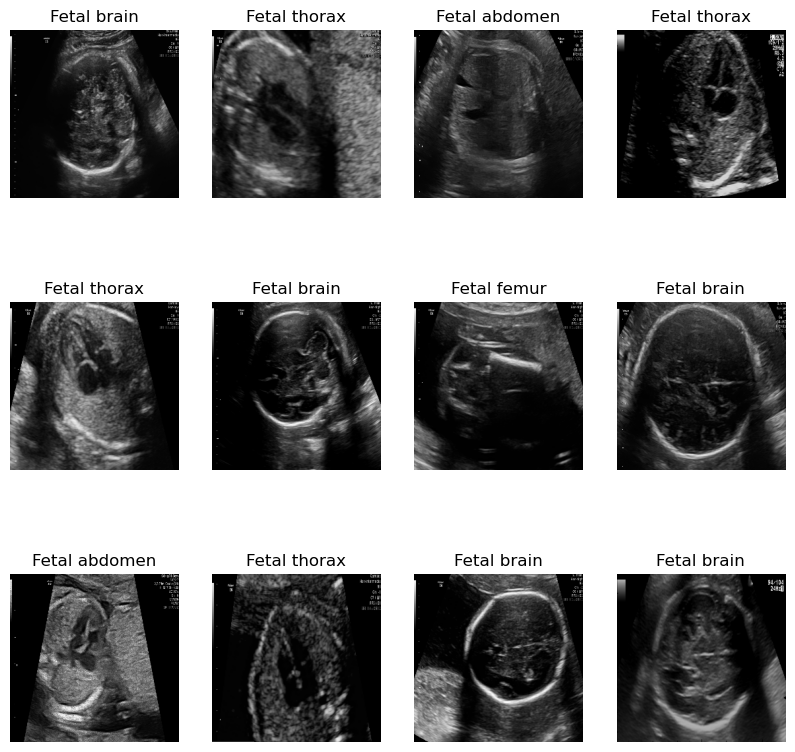

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in Dataset.take(1): # Iterate through the first batch of images and labels in the dataset
    for i in range(12):     # Loop through a subset of images in the batch
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [7]:
# 80% data => training
# 20% data => 10% validation, 10% test

In [8]:
train_size = 0.8
len(Dataset)*train_size

41.6

In [10]:
train_ds = Dataset.take(41)
len(train_ds)

41

In [11]:
test_ds = Dataset.skip(41)
len(test_ds)

11

In [12]:
val_size = 0.1
len(Dataset)*val_size

5.2

In [13]:
val_ds = test_ds.take(5)
len(val_ds)

5

In [14]:
test_ds = test_ds.skip(5)
len(test_ds)

6

In [15]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
     """
    Splits a given dataset into training, validation, and test sets based on specified proportions.
    
    Args:
        ds (tf.data.Dataset): The input dataset to be partitioned.
        train_split (float): Proportion of data to be allocated for the training set (default is 0.8).
        val_split (float): Proportion of data to be allocated for the validation set (default is 0.1).
        test_split (float): Proportion of data to be allocated for the test set (default is 0.1).
        shuffle (bool): Whether to shuffle the dataset before partitioning (default is True).
        shuffle_size (int): Number of elements used for shuffling (default is 10000).
        
    Returns:
        tf.data.Dataset, tf.data.Dataset, tf.data.Dataset: Partitioned training, validation, and test datasets.
    """
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [16]:
train_ds,val_ds,test_ds = get_dataset_partition_tf(Dataset)

In [17]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

41
5
6


 ### Cache, shuffle and prefetch the dataset for faster access and optimized pipeline

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Preprocessing the image dataset using resize and rescaling

In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

### Further preprocessing for horizontal and vertical rotation

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [21]:
# Define the number of channels in the input images
NUM_CHANNELS = 3

# Define the input shape for the model
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)

# Define the number of classes in the classification task
n_classes = 4

# Create a sequential model for image classification
model = models.Sequential([
    resize_and_rescale, # Preprocessing steps
    data_augmentation,
    # Convolutional layers
    layers.Conv2D(32, (3,3), activation='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    # Flatten the output and add dense layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    # Output layer with softmax activation for classification
    layers.Dense(n_classes, activation='softmax'),
])

# Build the model with the specified input shape
model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [23]:
# Compiling the model with specified optimizer, loss, and metrics
model.compile(
    optimizer='adam', # Using the Adam optimizer for gradient based optimization
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'] # Track accuracy as a metric during training
)

In [24]:
# Train the model using the training dataset
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose = 1,
    validation_data=val_ds
)

Epoch 1/50
41/41 [==============================] - 42s 942ms/step - loss: 1.3563 - accuracy: 0.3362 - val_loss: 1.3672 - val_accuracy: 0.2500
Epoch 2/50
41/41 [==============================] - 36s 884ms/step - loss: 1.1936 - accuracy: 0.4320 - val_loss: 1.0318 - val_accuracy: 0.5562
Epoch 3/50
41/41 [==============================] - 36s 889ms/step - loss: 0.9883 - accuracy: 0.5904 - val_loss: 0.8898 - val_accuracy: 0.6687
Epoch 4/50
41/41 [==============================] - 37s 891ms/step - loss: 0.8527 - accuracy: 0.6940 - val_loss: 0.6721 - val_accuracy: 0.7625
Epoch 5/50
41/41 [==============================] - 36s 867ms/step - loss: 0.7815 - accuracy: 0.7117 - val_loss: 0.7346 - val_accuracy: 0.7500
Epoch 6/50
41/41 [==============================] - 35s 854ms/step - loss: 0.6831 - accuracy: 0.7643 - val_loss: 0.7646 - val_accuracy: 0.7125
Epoch 7/50
41/41 [==============================] - 35s 863ms/step - loss: 0.6485 - accuracy: 0.7635 - val_loss: 0.5969 - val_accuracy: 0.7875

In [25]:
scores = model.evaluate(test_ds) # Evaluate the model's performance on the test dataset

6/6 [==============================] - 3s 173ms/step - loss: 0.1639 - accuracy: 0.9427


In [26]:
scores

[0.1638924926519394, 0.9427083134651184]

In [27]:
history.history.keys() # Retrieve the keys

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [28]:
len(history.history['accuracy']) # Get the length of the 'accuracy' values in the history dictionary

50

In [29]:
# Retrieve training and validation accuracy values from history dictionary
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

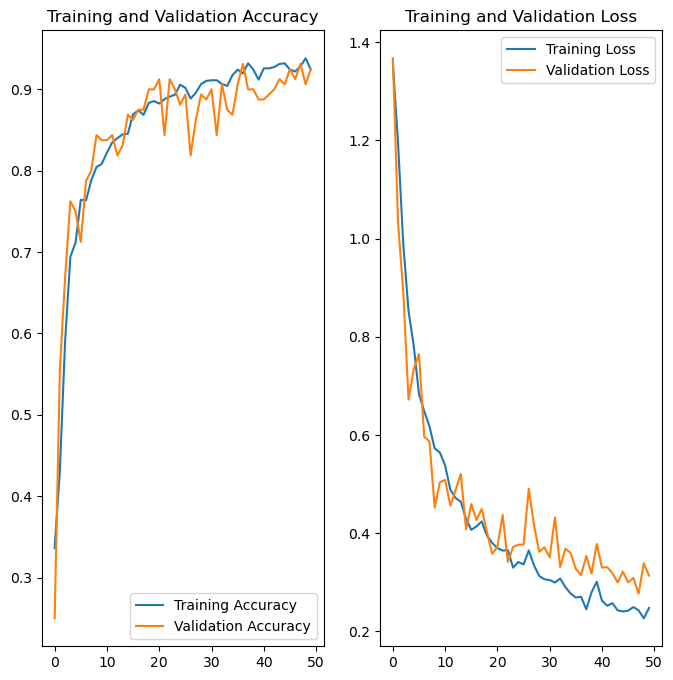

In [30]:
plt.figure(figsize=(8,8)) # Create a figure with subplots for accuracy and loss visualization

# Subplot for accuracy visualization
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Subplot for loss visualization
plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Display the plots
plt.show()

First image to predict
Actual label: Fetal abdomen
1/1 [==============================] - 0s 280ms/step
Predicted Label: Fetal abdomen


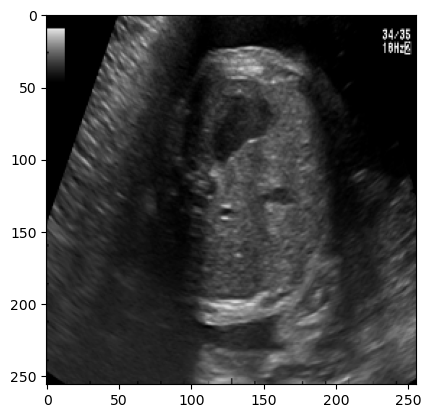

In [31]:
import numpy as np

# Make predictions for the entire batch
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = (images_batch[0].numpy().astype('uint8'))
    first_label = labels_batch[0]
    
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [32]:
def predict(model,img):
    # Convert the image to an array and expand dimensions to create a batch
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    # Make predictions using the model
    predictions = model.predict(img_array)
    
    # Retrieve the predicted class and confidence level
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 26ms/step


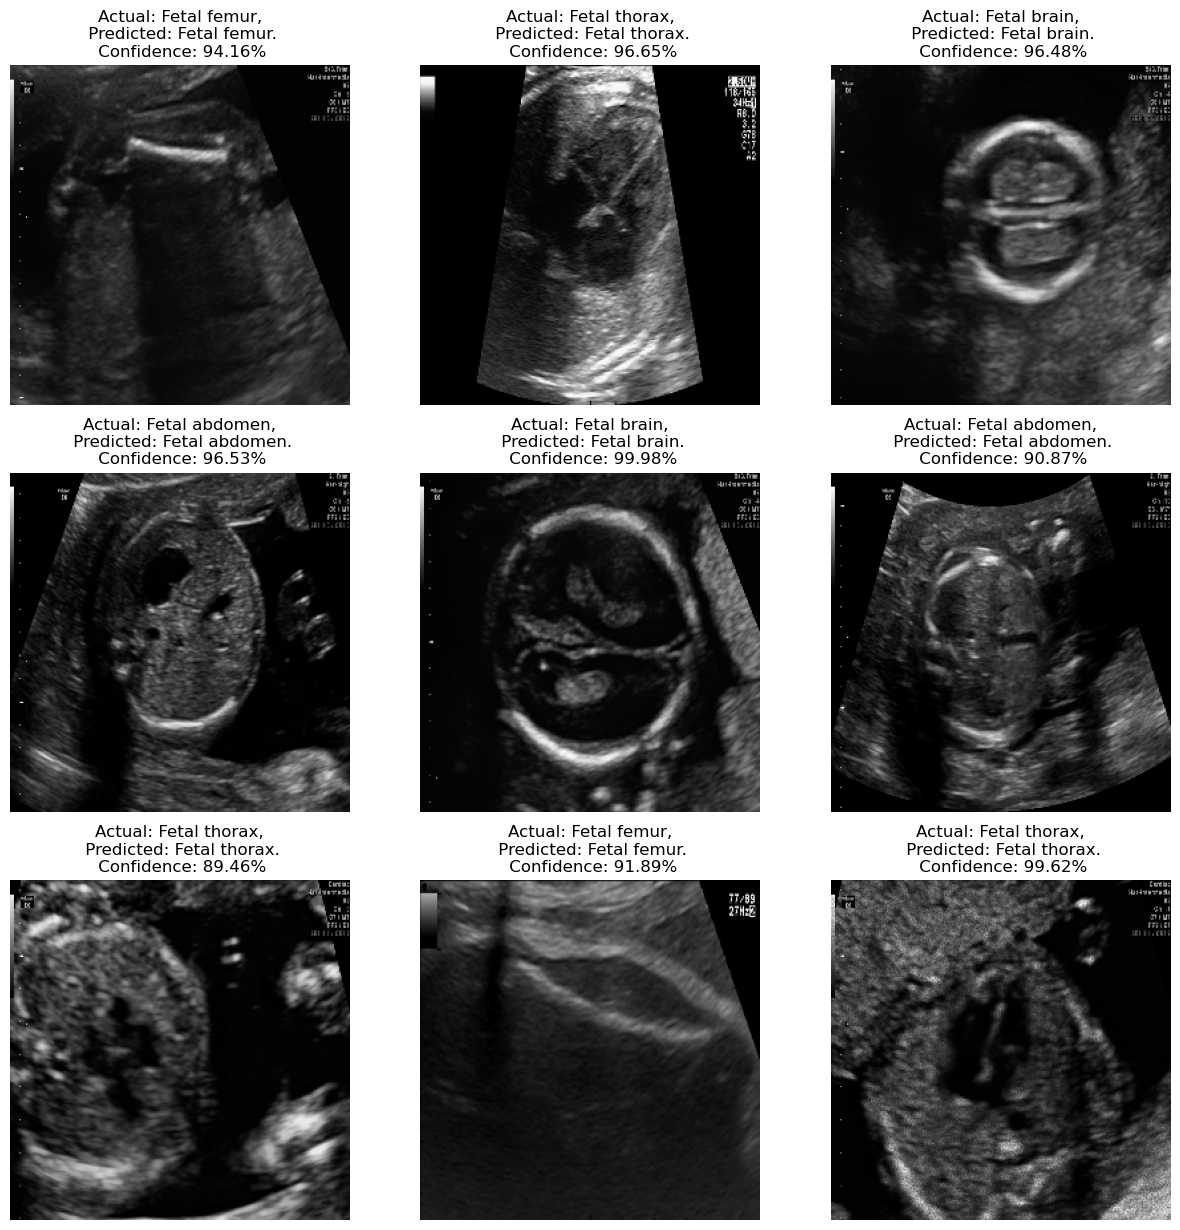

In [33]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        # Use the predict function to get predicted class and confidence
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [34]:
model_version=1
model.save(f"../models/{model_version}") # Save the trained model to the specified directory for future use

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [35]:
# Create a dataset using images from the external test folder
prediction_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "External Test images-20230824T140412Z-001",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 40 files belonging to 1 classes.


1/1 [==============================] - 0s 24ms/step


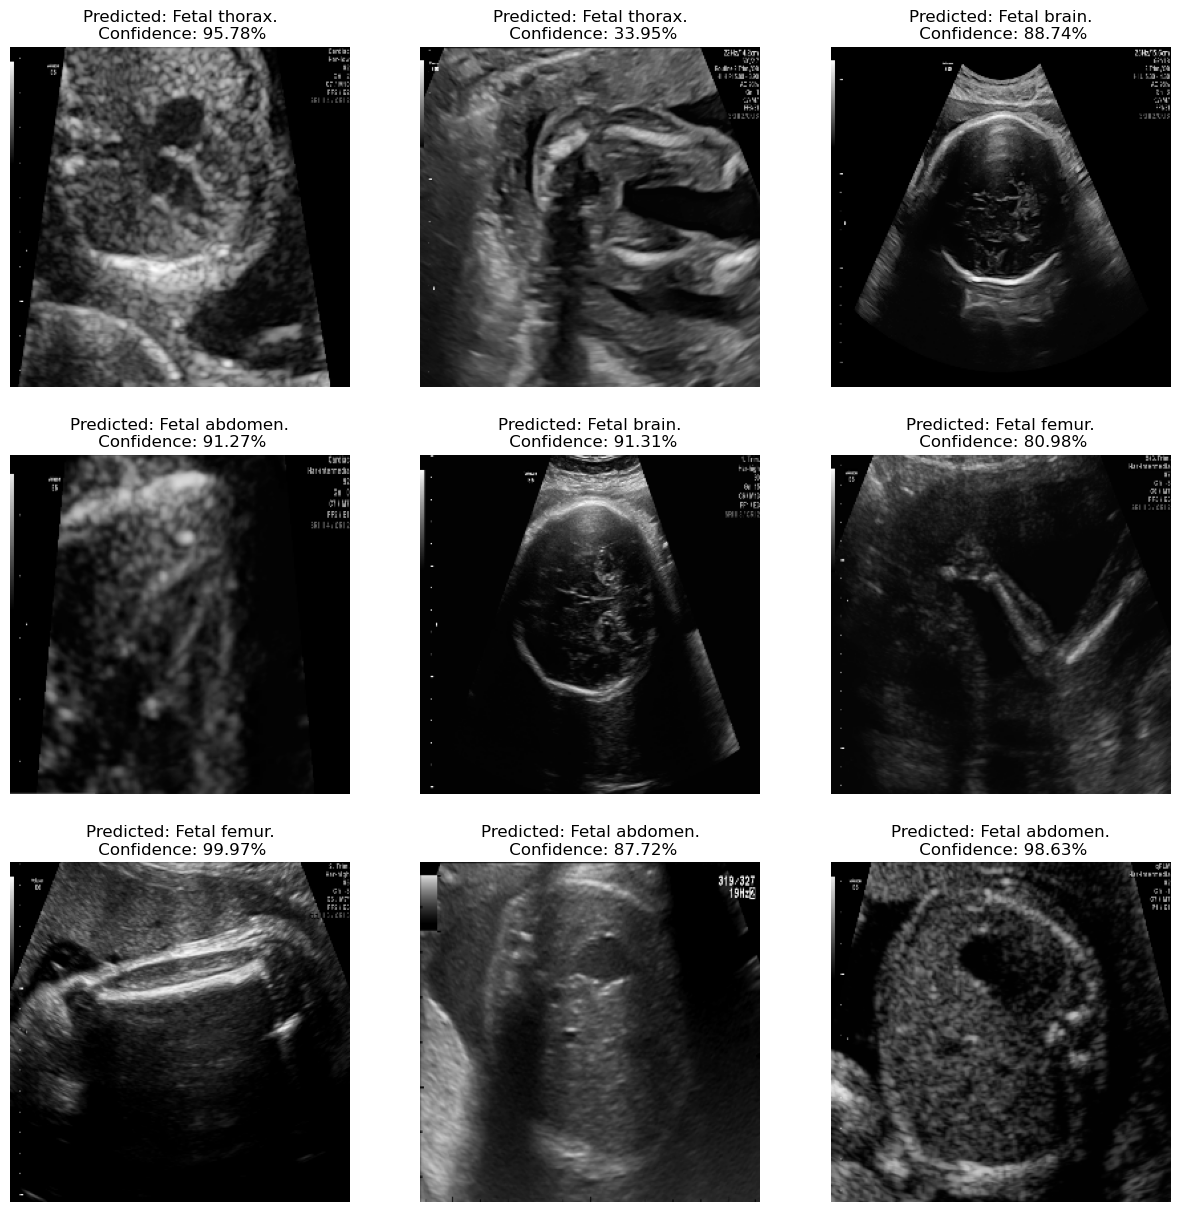

In [38]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1): #1st batch of external test images
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        
        # Predict the label of the image along with confidence
        plt.title(f"Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

1/1 [==============================] - 0s 27ms/step


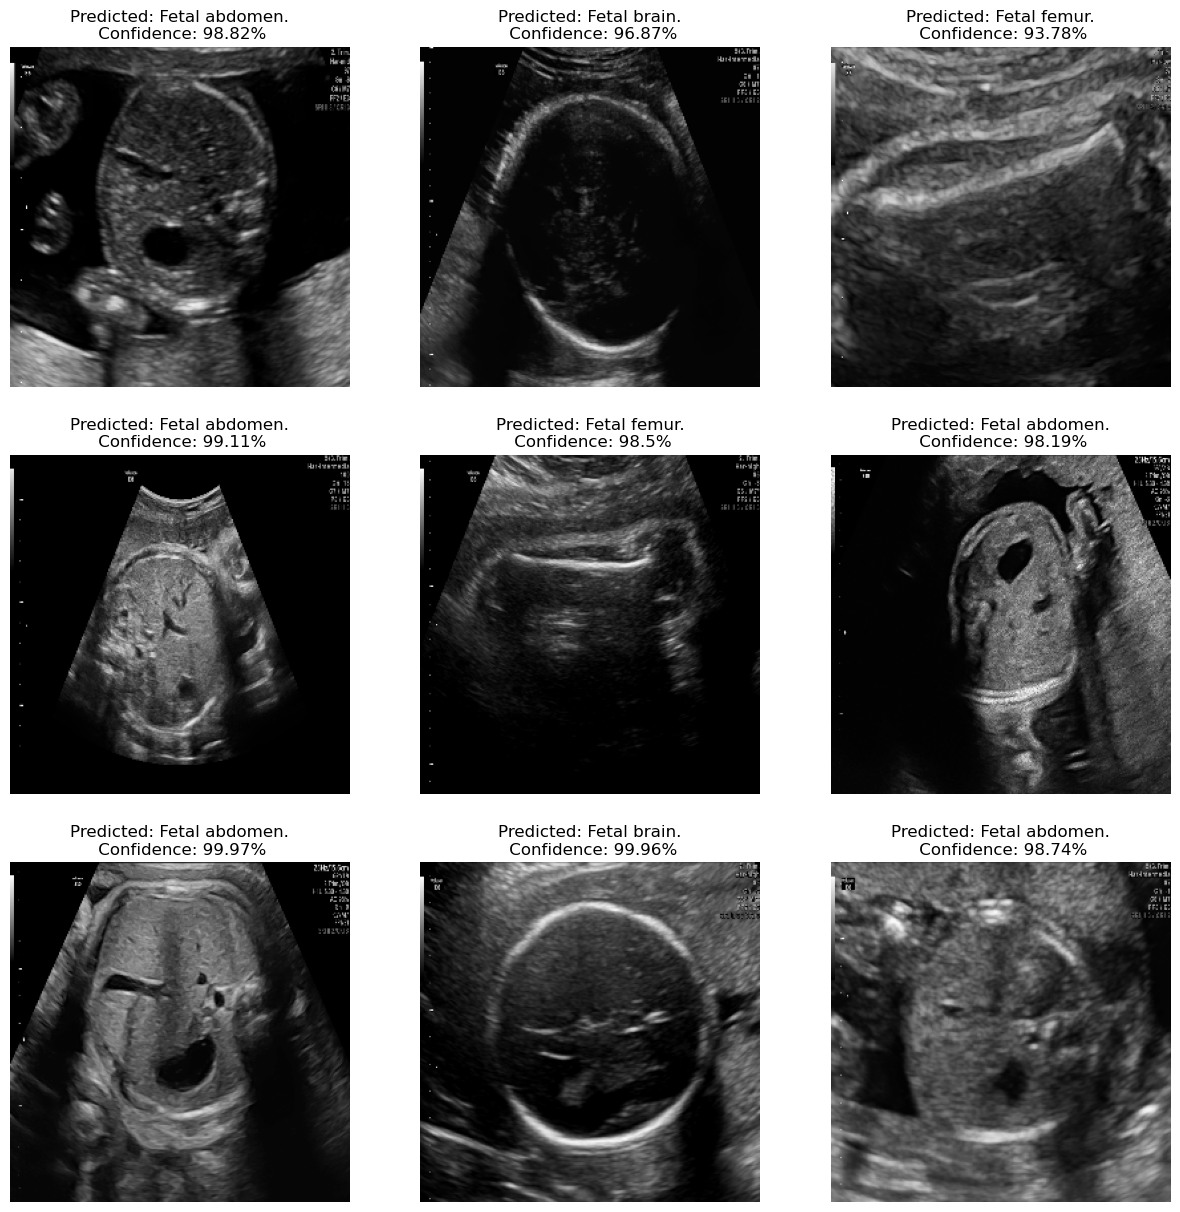

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(2): #2nd batch of external test images
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        
        plt.title(f"Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
import pickle

# Save the trained model using pickle
model_filename = "trained_model.pkl"
with open(model_filename, 'wb') as model_file:
    pickle.dump(model, model_file)
